In [182]:
from __future__ import annotations
from qiskit import QuantumCircuit
from transpiler.qasm2_reader import load_qasm, from_qasm2_to_braket
from bqskit.ext import bqskit_to_qiskit,qiskit_to_bqskit
from qiskit_aer import AerSimulator
from qiskit import transpile
import pennylane as qml
import numpy as np
from braket.devices import LocalSimulator
from braket.circuits import Circuit as braket_Circuit
from transpiler.transpile import transpile_circuit as bqskit_transpiler
from transpiler.transpile import get_noisy_counts
from qiskit.circuit.random import random_circuit
from qiskit.transpiler import CouplingMap
from qiskit.circuit.quantumregister import Qubit, QuantumRegister
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

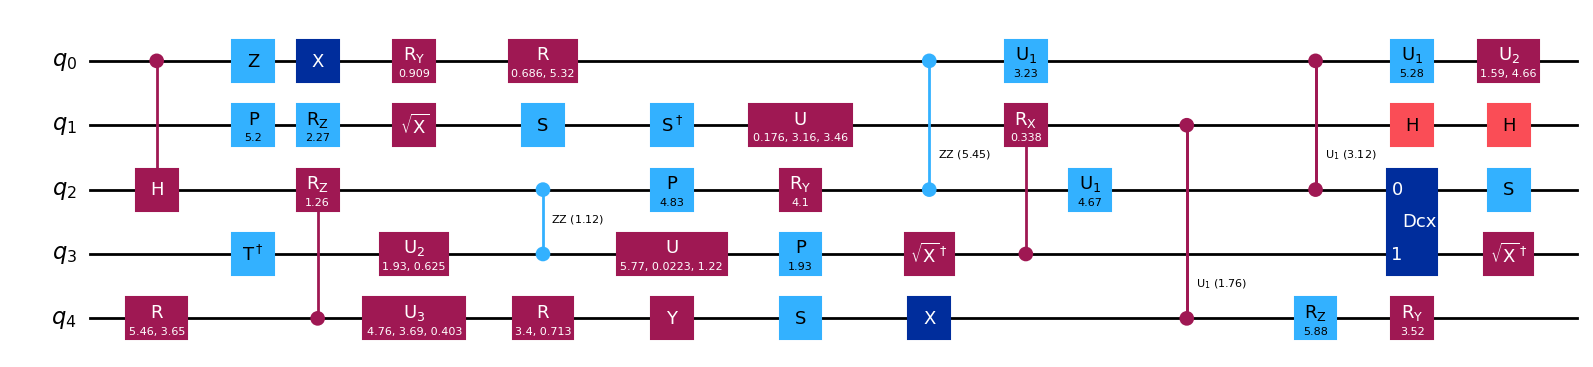

In [183]:
# Create a 4-qubit quantum circuit
# Generate a random 4-qubit circuit with a depth of 5
qc = random_circuit(5,max_operands=2, depth=10, measure=False)
qc_bqskit=qiskit_to_bqskit(qc)
qc.draw("mpl")

In [184]:
 # Initialize the latest AerSimulator
simulator = AerSimulator()

coupling_map = CouplingMap([
    (0, 1), (0, 3), (1, 4), (2, 3),
    (2, 7), (3, 4), (3, 8), (4, 5), (4, 9),
    (5, 6), (5, 10), (6, 11), (7, 8), (7, 12),
    (8, 9), (8, 13), (9, 10), (9, 14), (10, 11),
    (10, 15), (11, 16), (12, 13), (13, 14), (13, 17),
    (14, 15), (14, 18), (15, 19), (15, 16),
    (17, 18), (18, 19)
])
initial_layout=[8,9,10,14,4]
# Transpile the circuit for the simulator
qc_qiskit = transpile(qc, simulator,optimization_level=3,basis_gates=['rx','ry','cz'],coupling_map=coupling_map,initial_layout=initial_layout)

def inverse_permutation(permutation):
    """Compute the inverse of a given permutation."""
    inverse = np.empty_like(permutation)
    inverse[permutation] = np.arange(len(permutation))
    return list(inverse)

inverse_layout=inverse_permutation(initial_layout + [i for i in range(20) if i not in initial_layout])
qc_qiskit = transpile(qc_qiskit,optimization_level=0,initial_layout=inverse_layout)


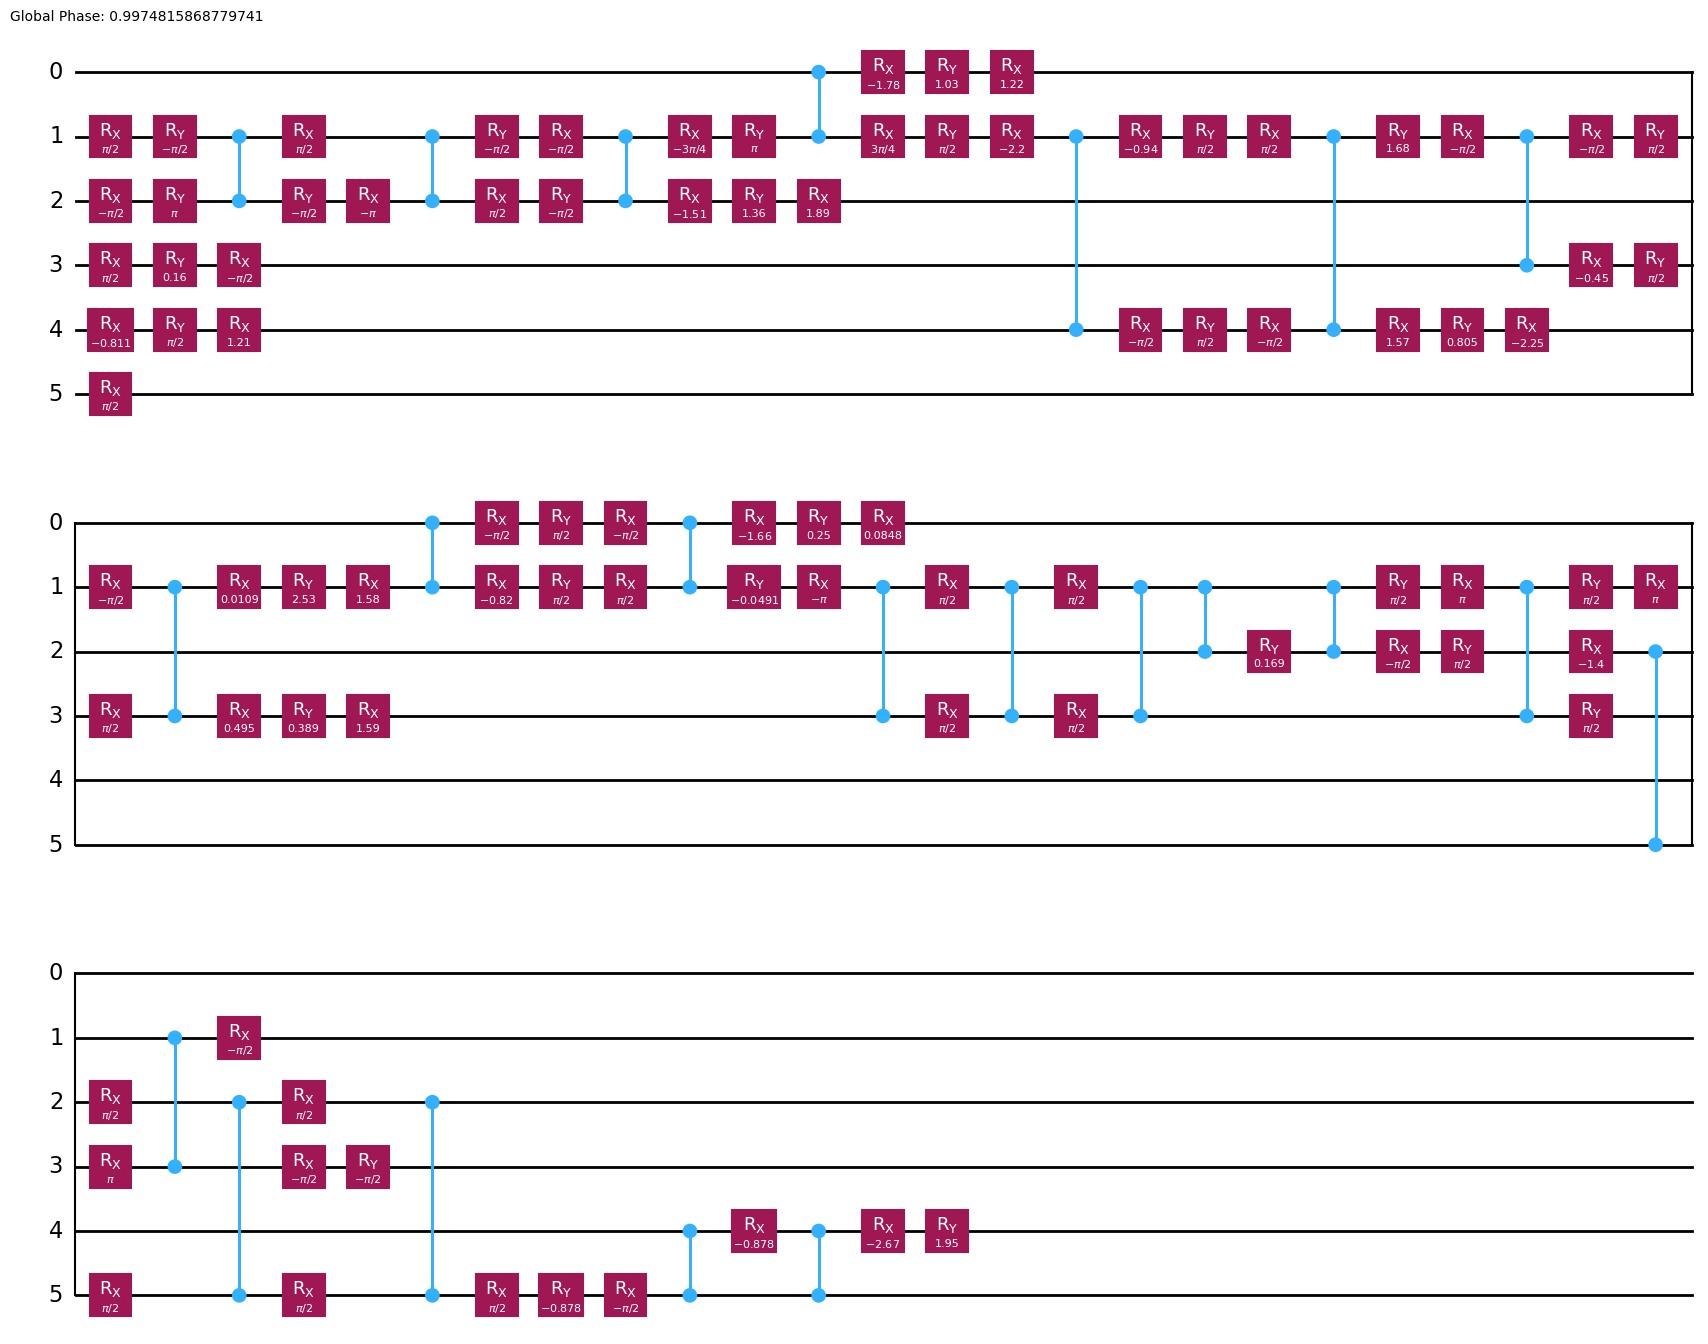

In [185]:
def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)
remove_idle_qwires(qc_qiskit).draw()

qc_qiskit=remove_idle_qwires(qc_qiskit)
qc_qiskit.draw("mpl")
# qc_qiskit.draw()


In [186]:
get_noisy_counts(qc_qiskit,1000,0.00,0.000,0.00)

{'000000': 67,
 '000001': 30,
 '000010': 27,
 '000011': 43,
 '000100': 10,
 '000101': 14,
 '000110': 6,
 '000111': 8,
 '010000': 11,
 '010001': 8,
 '010010': 6,
 '010011': 8,
 '010100': 44,
 '010101': 52,
 '010110': 19,
 '010111': 36,
 '100000': 92,
 '100001': 51,
 '100010': 34,
 '100011': 51,
 '100100': 27,
 '100101': 24,
 '100110': 5,
 '100111': 27,
 '110000': 31,
 '110001': 18,
 '110010': 15,
 '110011': 24,
 '110100': 65,
 '110101': 67,
 '110110': 21,
 '110111': 59}

In [6]:
# Step 3: Transpile the circuit to MS gates
qc_qiskit_transpiled = bqskit_transpiler(qc_qiskit,device="Aria",optimization_level=2,synthesis_epsilon=1e-4)
print(qc_qiskit_transpiled)

CRITICAL:bqskit.compiler.compiler:Compiler interrupted.


KeyboardInterrupt: 

In [4]:
qml_circuit = qml.from_qiskit(qc_qiskit_transpiled)
print("Transpiled result",np.round(np.abs(qml.matrix(qml_circuit, wire_order=list(range(qc_qiskit.num_qubits)))().T[0])**2,5))


Transpiled result [9.9986e-01 0.0000e+00 7.0000e-05 0.0000e+00 7.0000e-05 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]


In [5]:
# print("Noise 0     simulation result:", get_noisy_counts(qc_qiskit_transpiled,0.00,0.000,0.00))
# print("Noiseless simulation result:",np.abs(qml.matrix(qml_circuit, wire_order=list(range(qc_qiskit.num_qubits)))().T[0])**2)
print("Noisy     simulation result:", get_noisy_counts(qc_qiskit_transpiled,0,0.00,0.000,0.00))#check
print("Noisy     simulation result2:", get_noisy_counts(qc_qiskit,0,0.00,0.000,0.00))#check

Noisy     simulation result: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Noisy     simulation result2: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
print("Noisy     simulation result:", get_noisy_counts(qc,0,0.00,0.000,0.00))#check
print("Noisy     simulation result2:", get_noisy_counts(qc_qiskit,0,0.00,0.000,0.00))#check

ValueError: Unknown gate Adjoint(T) encountered. Please check the circuit.

In [ ]:
qc_qiskit